<h1> Predicting User Knowledge Level Using KNN Classification</h1>
<h2> DSCI 100: Group 38 Final Project </h2>

<b>Introduction: </b>

- <u>Background: </u>
- <u>Dataset description: </u>
    - Dataset title:  <b> <a href="https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling"> User Knowledge Modeling Data Set </a> </b>
    - The dataset we are using is the “User Knowledge Modelling Dataset” from the UCI Machine Learning Repository in which the population consists of 403 undergraduate students in the Department of Electrical Education of Gazi University in the 2009 semester. 
    - Dataset terminology:
    
        <b>STG</b> - The degree of study time for goal object materials

        <b>SCG</b> - The degree of repetition number of user for goal object materials

        <b>STR</b> - The degree of study time of user for related objects with goal object

        <b>LPR</b> - The exam performance of user for related objects with goal object

        <b>PEG</b> - The exam performance of user for goal objects

        <b>UNS</b> - The knowledge level of user
    
- <u>Objectives</u>: From the raw dataset, the target value is UNS and is classified through input values: STG, SCG, STR, LPR, and PEG. Our objective is to determine the category of UNS assigned to the user based on PEG (we will discuss later why we only choose this variable as the predictor) with k-NN classification. The target value is the knowledge level of students/ ‘users’ about the subject of Electrical DC Machines in which its features is PEG and its categories are:
    - Very low
    - Low
    - Middle
    - High
    
    <br>

<b> Methods & Results: 

- <u>Preliminary exploratory data analysis: </u>

Firstly, we loaded in the packages that were needed, and set the seed so that everything is reproducible for the data analysis. </i>

In [13]:
library(tidyverse)
library(readxl)
library(digest)
library(dplyr)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

set.seed(9999)

<br>

We loaded the data into R by downloading the file, where we then read the training dataset. Then we selected all the variable columns from the data and mutated UNS as a factor. <b>There was no need to wrangle the data into tidy format since it was already provided as such. </b> Each row is a single observation, each column is a single variable and each value is a single cell.
    
Now we need to choose the suitable predictor(s) for our prediction. We wanted to use the ggpairs function to find the correlations between all the variables and UNS, so that we can choose the ones with relatively strong correlations with UNS as predictor(s). But we noticed that UNS was not in the numeric form, so we assigned each UNS category a numeric value, from 1 to 4, representing the lowest level to the highest level. Notice below we used c(1,4,2,3) instead of normal ordering because the first four rows of the UNS column in the training dataset are "very_low, high, low, middle". They are not from the lowest level to the highest level as we wanted. That is why we needed to assign the categories as 1, 4, 2, and 3.

In [14]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
              "user_modeling_data.xls")        #loads data from the original source on the web 

original_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)
head(original_training,10)

whole_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)%>%              #select columns from STG to UNS
                     mutate(UNS = c(1,4,2,3)[as_factor(UNS)])      #change the categorical data of the UNS column into numeric form in specific order
head(whole_training,10)    # take a look at the first ten rows of the edited dataset

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low
0.00,0.00,0.50,0.20,0.85,High


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,1
0.08,0.08,0.10,0.24,0.90,4
0.06,0.06,0.05,0.25,0.33,2
⋮,⋮,⋮,⋮,⋮,⋮
0.15,0.02,0.34,0.40,0.01,1
0.20,0.14,0.35,0.72,0.25,2
0.00,0.00,0.50,0.20,0.85,4


Now we can see from the table above that all the four categories in the UNS column are assigned a number corresponding to the data point's knowledge level. So now we are able to use the ggpairs function to visualize the correlations between all variables with UNS.

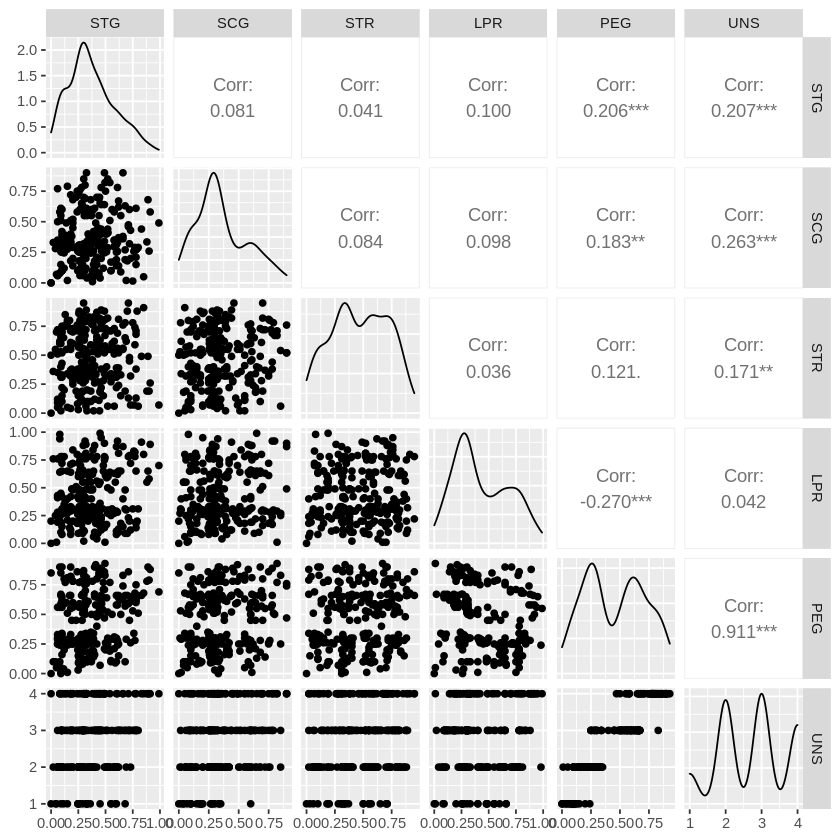

In [15]:
ggpairs(whole_training)

<br>
We can see from the above plot that only PEG has a strong positive correlation with UNS, at a value of 0.911. This is why we chose PEG as the only predictor, as all the other predictors have a very low correlation value.

<br>

Now we can just select the PEG and UNS columns for both training data and testing data from the original dataset. Since we have chosen the predictor, we no longer need to keep the UNS column in a numeric form. Notice that we renamed one of the values of the UNS column in the testing data to make all the categories have the same name. (The testing data represents the lowest level as "Very Low", but the training data uses "very_low" to represent the lowest level.) If we don't do this, the accuracy of our prediction would be seriously affected.

In [16]:
# create the training data
dataset_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (which consists of the training data)
                     select(PEG,UNS)%>%              #select only predictor and target variable columns
                     mutate(UNS = as_factor(UNS))   # change the UNS column into factor form
head(dataset_training,10)       # take a look at the first 10 rows of the training data

# create the testing data
dataset_testing <- read_excel('user_modeling_data.xls', sheet = 3)%>%     #only read the third sheet from the file (which consists of the testing data)
                     select(PEG,UNS)%>%             #select only predictor and target variable columns
                     mutate(UNS = ifelse(UNS == "Very Low", "very_low", UNS))%>%   # make all the values in UNS column same for training and testing data
                     mutate(UNS = as_factor(UNS))         # change the UNS column into factor form
head(dataset_testing,10)    # take a look at the first 10 rows of the testing data

New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.00,very_low
0.90,High
0.33,Low
⋮,⋮
0.01,very_low
0.25,Low
0.85,High


New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.05,very_low
0.14,Low
0.85,High
⋮,⋮
0.15,Low
0.80,High
0.07,very_low


In [17]:
dataset_testing$UNS <- ordered(dataset_testing$UNS, levels = c("very_low", "High", "Low", "Middle"))  #makes the factor levels of the training and testing data the same, originally was different

<br>

By making a table, we can see the distribution of each status in the training data in regards to their counts and percentages. </i>

In [25]:
num_UNS <- dataset_training %>%
           group_by(UNS) %>%        # group by the UNS column
           dplyr::summarise(count = n(),             #calculate the number of observations for each status of UNS, dplyr since R was confused on which library to use
                     percentage = n() / nrow(dataset_training) *100)    #calculates the percentage of each UNS category
num_UNS

UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


We also concluded there is no missing data in the training data. </b>

In [26]:
nrow(dataset_training%>%filter(is.na(UNS)))   # find the number of rows with missing data in UNS column
nrow(dataset_training%>%filter(is.na(PEG)))   # find the number of rows with missing data in PEG column

[1] 0

[1] 0

Here we calculated the mean of PEG scores for training data.

Through R, we also calculated the average PEG score for the training data to be 0.46

In [27]:
PEGavg <- dataset_training %>%
          summarize(PEGavg = mean(PEG))   #calculate the mean PEG score in the training set
PEGavg

PEGavg
<dbl>
0.4585388


- <u>Visualization relevant for exploratory data analysis related to the planned analysis:</u>

Lastly, We drew a bar plot to visualize the distribution of PEG (the exam performance of user for goal objects) over UNS (the knowledge level of user).

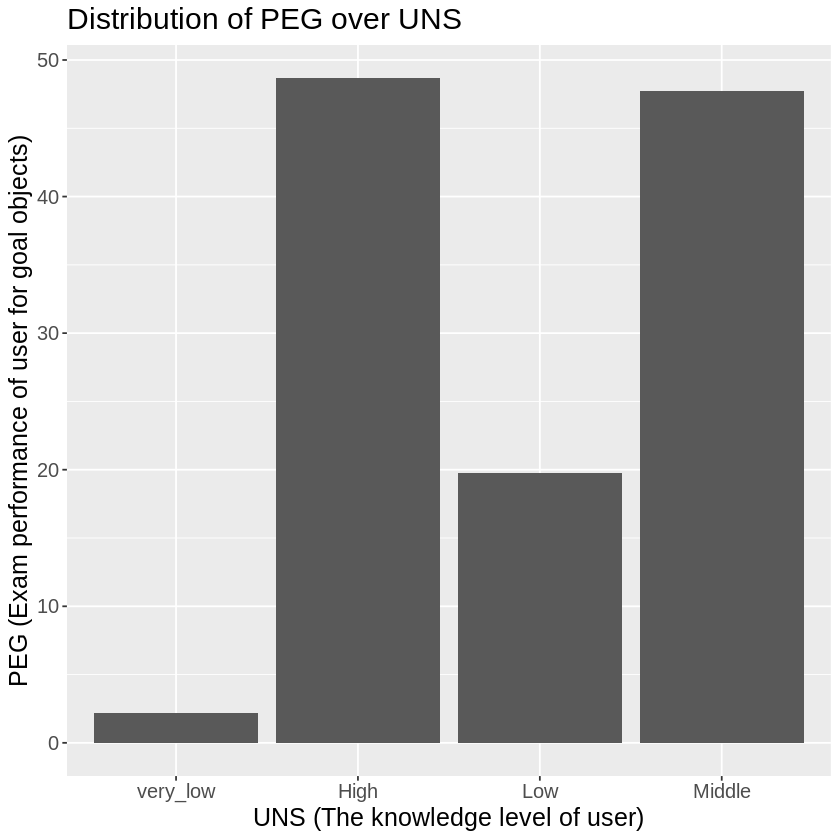

In [28]:
plot <- dataset_training %>%
         ggplot(aes(x = UNS, y = PEG)) + geom_bar(stat = "identity") + 
         labs(x = "UNS (The knowledge level of user)" , 
              y = "PEG (Exam performance of user for goal objects)") + 
         theme(text = element_text(size = 15))+
         ggtitle("Distribution of PEG over UNS")
plot

We can see from the plot that there are more users with increasing knowledge level of users. Most of the users have a middle to high level of knowledge, and the number of users with very low knowledge level is quite small.

<br>

- <u>Data analysis: </u>

We used cross validation to find the k value which gives us the highest accuracy. We can see from both the line plot and the first row of the table that K should be 14, since it gives us the highest accuracy at 84.07%.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,accuracy,multiclass,0.8406679,5,0.03606059,Preprocessor1_Model14
11,accuracy,multiclass,0.8405140,5,0.03641189,Preprocessor1_Model11
12,accuracy,multiclass,0.8405140,5,0.03641189,Preprocessor1_Model12
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,multiclass,0.7982067,5,0.01076237,Preprocessor1_Model03
2,accuracy,multiclass,0.7745987,5,0.01932981,Preprocessor1_Model02
1,accuracy,multiclass,0.7510662,5,0.02717302,Preprocessor1_Model01


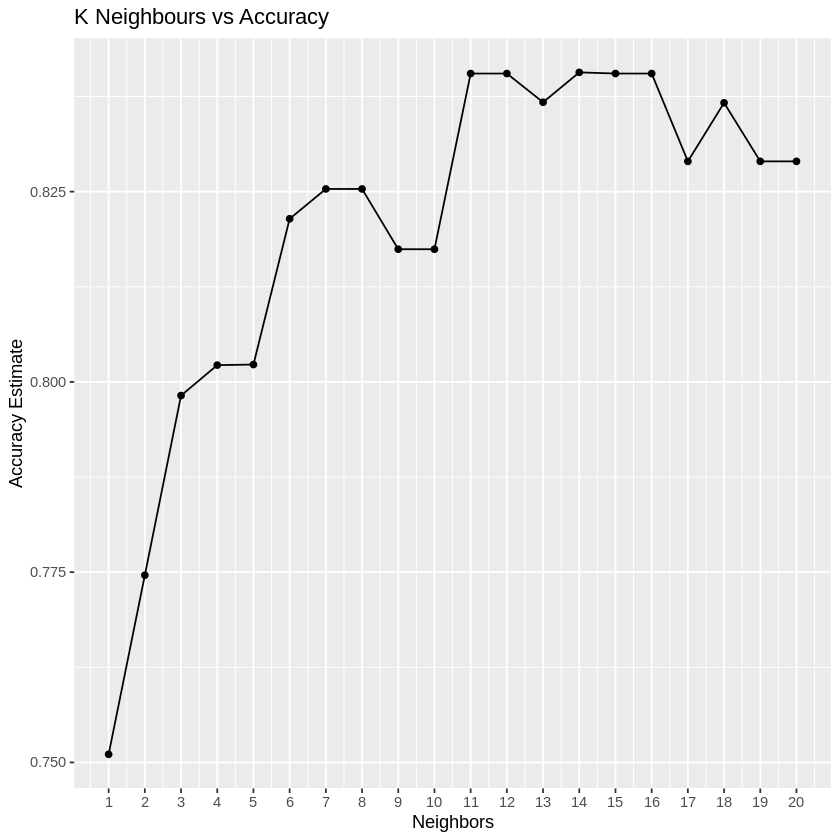

In [29]:
# Find the k value that results in the model having the highest accuracy using cross validation
set.seed(9999)
vfold <- vfold_cv(dataset_training, v = 5, strata = UNS)   # seperate the data into five random groups

recipe <- recipe(UNS ~ PEG, data = dataset_training) %>%   # selected our target variable to be UNS and predictor variable to be PEG
                step_scale(all_predictors()) %>%  
                step_center(all_predictors()) # scaling and centering the predictor variable so that each variable is worth the same

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%  #tuning the K value
             set_engine("kknn") %>%      #tells R that we're using the K-nearest neighbors algorithm for our model
             set_mode("classification")  #tells R that we're using classification for our model    

wkflw <- workflow() %>%                              #creates a workflow
             add_recipe(recipe) %>%                  #adds the recipe into the workflow
             add_model(knn_spec)                     #adds the model into the workflow

gridvals <- tibble(neighbors = seq(from = 1, to = 20))   #creates the list of k values we are going to test

results <- wkflw  %>%
           tune_grid(resamples = vfold, grid = gridvals)  %>%
           collect_metrics() %>%          
           filter(.metric == "accuracy")%>%    #filters out only the rows with the accuracy metric               
           arrange(desc(mean))                 #arranges the rows in descending order of accuracy
results

accuracy_vs_k <- ggplot(results, aes(x = neighbors, y = mean)) +     #graphs a K vs accuracy scatterplot (to represent which K value maximizes the model's accuracy)
                 geom_point() + geom_line() +                        #specifies that each point in the graph will have a dot and lines that connects each dot together
                 labs(x = "Neighbors", y = "Accuracy Estimate") +    #gives the x and y axis titles
                 scale_x_continuous(breaks = seq(0, 20, by = 1)) +   #makes it easier to match each point in the graph with its k value
                 ggtitle("K Neighbours vs Accuracy")                 #gives the graph a title

accuracy_vs_k

kmin <- results %>%           #find the k value with highest accuracy
        slice(1) %>%          #slices the first row of the dataframe to get the row with the highest accuracy (since the dataframe was arranged by accuracy in descending order)
        pull(neighbors)       #pulls the number of neighbors in the neighbors column 

Now that we have calculated the most suitable K value for the model, we just plugged it in and ran the classifier.

In [30]:
set.seed(9999)
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%      # plug in the best k value that we found above
              set_engine("kknn") %>%      
              set_mode("classification")

knn_fit <- workflow() %>%      
           add_recipe(recipe) %>%             #adds the same recipe above
           add_model(knn_spec_2) %>%          #adds the new model with the best k-value that we found above
           fit(data = dataset_training)       #fit the training data

predictions <- knn_fit %>%                   #fits the workflow
               predict(dataset_testing) %>%  #predicts the UNS value  for each observation in the testing data
               bind_cols(dataset_testing)    #puts the column with all the predictions into the testing dataframe
predictions


summary <- predictions %>%
            metrics(truth = "UNS", estimate = ".pred_class") %>%  #determines the accuracy (and other metrics) based on each testing set observation's predicted UNS value and actual UNS value
           filter(.metric == "accuracy")%>%                       #filters out all the rows with the accuracy metric since that is the only thing we need
           select(.estimate)                                      #selects the accuracy value
summary

.pred_class,PEG,UNS
<fct>,<dbl>,<ord>
very_low,0.05,very_low
Low,0.14,Low
High,0.85,High
⋮,⋮,⋮
Low,0.32,Low
Middle,0.57,Middle
Low,0.24,Middle


.estimate
<dbl>
0.8689655


In [31]:
conf_mat <- predictions %>%          
            conf_mat(truth = UNS, estimate = .pred_class) #creates a confusion matrix so that we can see how many predictions for each category the model predicted correctly
conf_mat

          Truth
Prediction very_low High Low Middle
  very_low       21    0   0      0
  High            0   35   0      0
  Low             5    0  45      9
  Middle          0    4   1     25

<br>

- <u>Visualization of the analysis: </u>

<b> Discussion:

<b> Rerferences: